# Topic Model and Correlation

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from wordcloud import WordCloud
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [2]:
#load datset
fname = 'data/new-york-times-articles/nytimes_news_articles.txt'
articles = []
errs = 0
with open(fname, 'r') as f:
    art = []
    while True:
        line = f.readline()
        if not line:
            break
        if 'URL' in line:
            if art != []:
                paper = ' '.join(art)
                if 'No corrections appeared in print' not in paper: #error papers
                    articles.append(paper)
                else:
                    errs += 1
            art = []
        elif line not in {'\n', ' '}:
            art.append(line.rstrip('\n'))

In [3]:
print(len(articles), errs)

8879 6


In [4]:
class Vocab(TfidfVectorizer):
    def __init__(self, texts, **kwargs):
        super(Vocab, self).__init__(**kwargs)
        self.fit(texts)

    def __len__(self):
        return len(self.vocabulary_)
    
    def _to_bow(self, sent):
        prep = self.build_preprocessor()
        analyzer = self.build_analyzer()
        seq = analyzer(prep(sent))
        return [w for w in seq if w in self.vocabulary_]

    def _to_indices(self, sent):
        return [self.vocabulary_[w] for w in self._to_bow(sent)]


def save_model(model, filename):
    print('saving model to %s ...' % filename)
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
    print('loading model from %s ...' % filename)
    return pickle.load(open(filename, 'rb'))

In [5]:
nlp = spacy.load('en_core_web_sm')
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    def __call__(self, doc):
        return [t.lemma_ for t in self.wnl(doc)]

In [6]:
vocab_size = 15000

kwargs = {'stop_words': 'english', 'max_df': 0.5, 'min_df': 3, 'ngram_range': (1, 1),
            'max_features': vocab_size, 'strip_accents': 'unicode'}
try:
    vocab = load_model('vocab.mode')
except:
    print('... creating new model')
    vocab = Vocab(articles, tokenizer=LemmaTokenizer(), **kwargs)

loading model from vocab.mode ...
... creating new model


In [88]:
print(len(vocab))
save_model(vocab, 'model/vocab.mod')

15000
saving model to model/vocab.mod ...


In [89]:
text = 'mr. trump and colleagues\n^ are going to do something about it. Australia is highly concerned.'
print(vocab._to_bow(text))

['trump', 'colleague', 'australia', 'highly', 'concerned']


## Topic extraction

In [62]:
import pyLDAvis
pyLDAvis.enable_notebook()
import gensim

In [63]:
arts_in_bow = [vocab._to_bow(art) for art in articles]
dct = gensim.corpora.Dictionary(arts_in_bow)
corpus = [dct.doc2bow(a) for a in arts_in_bow]

In [64]:
num_topics = 20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dct, passes=5, 
                                           alpha=[0.01]*num_topics, eta=[0.01]*len(dct.keys()))
if not os.path.exists('model'):
    os.makedirs('model')
ldamodel.save('model/lda.gensim')
topics = ldamodel.print_topics(num_words=30)
for topic in topics:
    print(topic)

(0, '0.015*"(" + 0.015*")" + 0.009*"play" + 0.009*"film" + 0.008*"music" + 0.007*";" + 0.006*"ms" + 0.005*"book" + 0.005*"work" + 0.005*"theater" + 0.005*"movie" + 0.005*"song" + 0.004*"write" + 0.004*"star" + 0.004*"album" + 0.004*"performance" + 0.004*"american" + 0.003*"dance" + 0.003*"musical" + 0.003*"world" + 0.003*"award" + 0.003*"festival" + 0.003*"character" + 0.003*"prince" + 0.003*"black" + 0.003*"production" + 0.003*"director" + 0.003*"broadway" + 0.003*"york" + 0.003*"story"')
(1, '0.045*"art" + 0.028*"museum" + 0.024*"artist" + 0.019*"work" + 0.019*"gallery" + 0.015*"redstone" + 0.012*"ms" + 0.012*"exhibition" + 0.009*"million" + 0.009*"director" + 0.009*"viacom" + 0.009*"painting" + 0.007*"auction" + 0.006*"contemporary" + 0.006*"sell" + 0.006*"angele" + 0.006*"los" + 0.005*"sculpture" + 0.005*"project" + 0.005*"piece" + 0.005*"collector" + 0.005*"collection" + 0.005*"curator" + 0.005*"sale" + 0.005*"company" + 0.004*"board" + 0.004*"national" + 0.004*"york" + 0.004*"mod

In [90]:
ldamodel.get_document_topics(dct.doc2bow(vocab._to_bow(articles[0])))

[(0, 0.023407618), (5, 0.7432948), (12, 0.23282614)]

In [91]:
ldamodel.state.get_lambda().shape

(20, 15000)

In [92]:
ldamodel.num_terms

15000

In [93]:
def get_topics(lda, num_words=30):
    l_topics = []
    for i in range(lda.num_topics):
        topic = ldamodel.state.get_lambda()[i]
        topic = topic / np.sum(topic)
        mx_indices = sorted(range(lda.num_terms), key=lambda a: topic[a], reverse=True)[:num_words]
        words = [lda.id2word[j] for j in mx_indices]
        l_topics.append(words)
    return l_topics

In [94]:
print(get_topics(ldamodel))

[['(', ')', 'play', 'film', 'music', ';', 'ms', 'book', 'work', 'theater', 'movie', 'song', 'write', 'star', 'album', 'performance', 'american', 'dance', 'musical', 'world', 'award', 'festival', 'character', 'prince', 'black', 'production', 'director', 'broadway', 'york', 'story'], ['art', 'museum', 'artist', 'work', 'gallery', 'redstone', 'ms', 'exhibition', 'million', 'director', 'viacom', 'painting', 'auction', 'contemporary', 'sell', 'angele', 'los', 'sculpture', 'project', 'piece', 'collector', 'collection', 'curator', 'sale', 'company', 'board', 'national', 'york', 'modern', 'artwork'], ['court', 'case', 'state', 'law', 'federal', 'judge', 'lawyer', 'justice', 'department', 'investigation', 'charge', 'official', 'office', 'city', 'legal', 'rule', 'york', 'attorney', 'decision', 'prosecutor', 'district', 'authority', 'public', 'file', 'issue', 'report', 'agency', 'appeal', 'government', 'criminal'], ['woman', 'ms', 'medium', 'news', 'facebook', 'post', 'write', 'social', 'man', 't

In [95]:
probs = ldamodel.state.get_lambda()
probs = probs / np.sum(probs, axis=1, keepdims=True)

In [96]:
np.sum(probs[0])

1.0

In [97]:
from numpy.linalg import norm

N = norm(probs, axis=1)
heatmap = (probs @ probs.T) / np.einsum('i, j->ij', N, N)

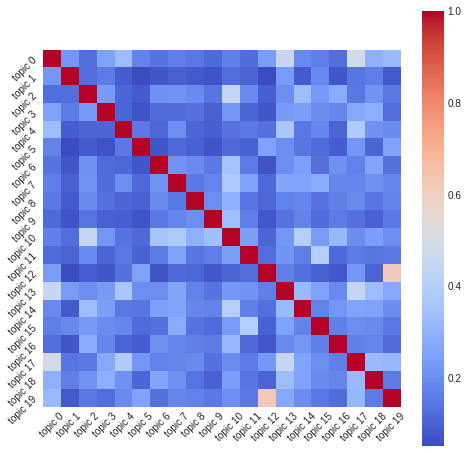

In [98]:
plt.figure(figsize=(8,8))
plt.imshow(heatmap, cmap='coolwarm')
plt.grid(None)
ticks = list(map(lambda a: 'topic %d' % a, range(ldamodel.num_topics)))
plt.xticks(np.arange(ldamodel.num_topics), ticks, rotation=45)
plt.yticks(np.arange(ldamodel.num_topics), ticks, rotation=45)
plt.colorbar()
plt.show()

In [99]:
from wordcloud import WordCloud

In [100]:
def vis_topic(topic, save_fname=None, **kwargs):
    wordcloud = WordCloud(**kwargs).generate(' '.join(topic))
    if save_fname is not None:
        wordcloud.to_file(save_fname)
    return wordcloud
num_topics = ldamodel.num_topics
w = h = 200
import cv2 as cv
mask = cv.imread('img/circle.jpg')
wcargs = {'width': w, 'height': h, 'background_color': "rgba(255, 255, 255, 0)", 'mode': "RGBA",
        'max_font_size': 100, 'min_font_size': 10, 'colormap': 'Paired', 'mask': mask}

In [101]:
topics = get_topics(ldamodel)
print(topics[0])

['(', ')', 'play', 'film', 'music', ';', 'ms', 'book', 'work', 'theater', 'movie', 'song', 'write', 'star', 'album', 'performance', 'american', 'dance', 'musical', 'world', 'award', 'festival', 'character', 'prince', 'black', 'production', 'director', 'broadway', 'york', 'story']


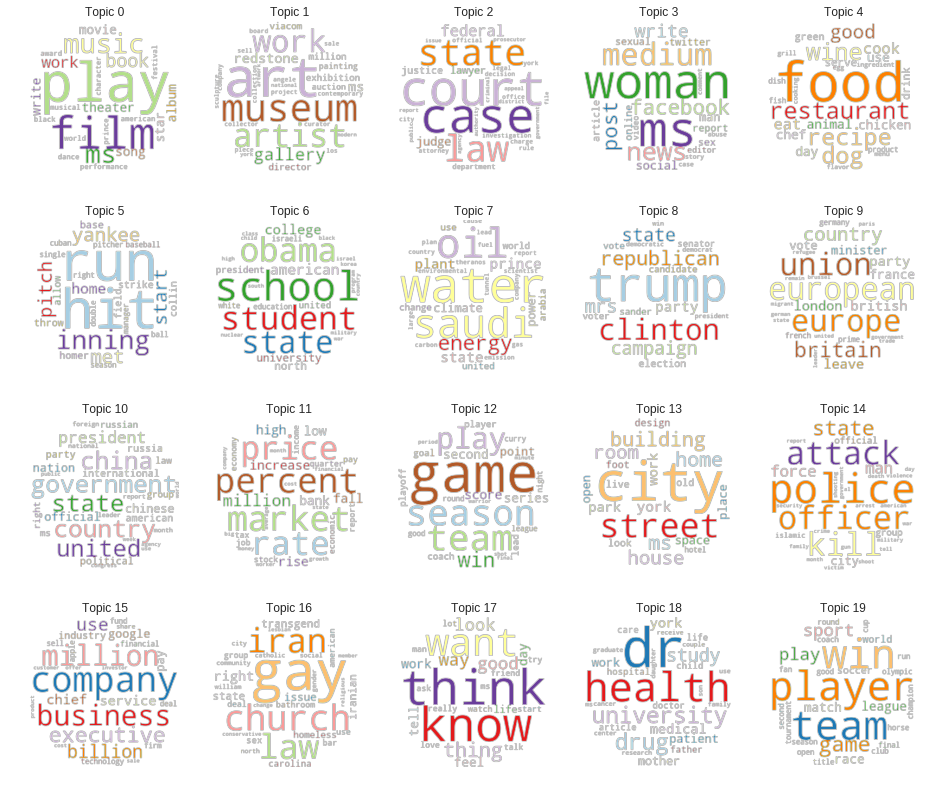

In [102]:
fig, axes = plt.subplots(num_topics // 5, 5, figsize=(16, 14))
for i in range(num_topics):
    r, c = i // 5, i % 5
    
    wordcloud = vis_topic(topics[i], **wcargs)
    axes[r, c].imshow(wordcloud, interpolation="bilinear")
    axes[r, c].axis("off")
    axes[r, c].set_title('Topic %d' % i)

wordcloud.to_file('wordcloud.png')
plt.show()

In [78]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

topic_clouds = [vis_topic(topic, **wcargs).to_array() for topic in topics]
coords = np.random.randint(num_topics // 2, size=(num_topics, 2))
print(topic_clouds[0].shape)

(283, 284, 4)


In [79]:
def draw_line(ax, p1, p2, linewidth, color='black'):
    ax.annotate(p2,
                xy=p2, xycoords='data',
                xytext=p1, size=20, va="center", ha="center",
                arrowprops=dict(arrowstyle="<|-|>",
                                connectionstyle="arc3,rad=-0.2",
                                fc="w", linewidth=linewidth, color=color))

def im_annot(im_array, coords, zoom=0.5):
    imagebox = OffsetImage(im_array, interpolation='bilinear', zoom=zoom)
    annot = AnnotationBbox(imagebox, coords, 
                        bboxprops=dict(facecolor='none', edgecolor='none', boxstyle='round'),
                      )
    return annot

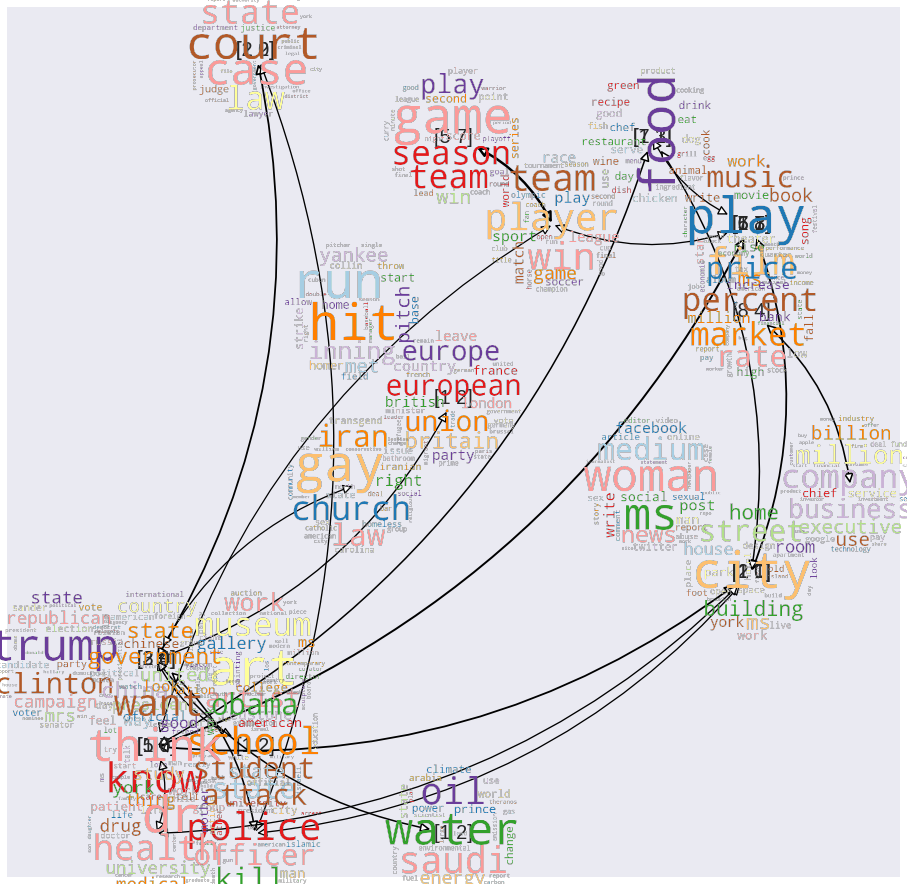

In [80]:
zoom = 1
margin = zoom // 2
lim = np.max(coords, axis=0)

fig, ax = plt.subplots(figsize=(16, 16))

ax.set_xlim(-0.5, lim[0] + 0.5)
ax.set_ylim(-0.5, lim[1] + 0.5)

for i, topic in enumerate(topic_clouds):
    ax.add_artist(im_annot(topic, coords[i]))
    for j in range(num_topics):
        if i >= j:
            continue
        link = heatmap[i, j]
        if link >= 0.3:
            draw_line(ax, coords[i], coords[j], link * 4)
    
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.grid(None)

#plt.draw()
plt.show()

In [81]:
def read_corpus(corpus, tokens_only=False):
    for i, line in enumerate(corpus):
        if tokens_only:
            yield line # use this func to tokenize a line
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(line, [i])

In [82]:
data = list(read_corpus(arts_in_bow))

In [83]:
data[0]

TaggedDocument(words=['washington', 'stellar', 'pitching', 'met', 'afloat', 'half', 'season', 'despite', 'offensive', 'woe', 'produce', 'encore', 'pennant', 'win', 'season', 'lineup', 'flounder', 'pitching', 'nick', 'bruise', 'stretch', 'ride', 'pitching', 'manager', 'terry', 'collin', 'wednesday', 'game', 'ride', 'right', 'problem', 'pitching', 'wednesday', '4', '2', 'loss', 'washington', 'national', 'cruel', 'limp', 'met', 'pitch', 'steven', 'matz', 'place', 'spot', 'starter', 'logan', 'verrett', 'allow', 'run', 'inning', 'large', 'deficit', 'met', 'lineup', 'overcome', 'max', 'scherzer', 'national', 'starter', 'chance', 'collin', 'add', 'later', 'just', 'pitcher', 'room', 'work', 'met', 'score', 'ninth', 'inning', 'gasp', 'run', 'homer', 'jame', 'loney', 'national', 'reliever', 'shawn', 'kelley', 'snap', 'streak', '23', 'scoreless', 'inning', 'team', 'met', 'sweep', 'game', 'series', 'fall', 'game', 'national', 'national', 'league', 'east', 'late', 'met', 'look', 'bad', '40', '37', 

Now how we retrieve topics from unseen document?

In [84]:
ldamodel.

SyntaxError: invalid syntax (<ipython-input-84-579650f7790d>, line 2)

In [140]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)
model.build_vocab(data)
%time model.train(data, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 5min 44s, sys: 4.77 s, total: 5min 49s
Wall time: 2min 19s


In [141]:
def sort_relevant(subj, model, data, vocab, topn=5):
    s = vocab._to_bow(preprocess(subj))
    rep = model.infer_vector(s)
    print(s)
    sims = model.docvecs.most_similar([rep], topn=topn)
    return sims

In [145]:
your_question = 'weaponary violence'
print('Your question is: %s' %your_question)

sims = sort_relevant(your_question, model, data, vocab, 10)
for i, perti in enumerate(sims):

    print(u'TOP %s RELEVANT %s: «%s»\n' % (i, perti, articles[perti[0]]))

Your question is: weaponary violence
['violence']
TOP 0 RELEVANT (3500, 0.6235047578811646): «In this episode of Modern Love: The Podcast, the actress Maria Bello (“Coyote Ugly,” “A History of Violence,” “ER”) reads her own Modern Love essay, “Coming Out as a Modern Family.” You can also hear the episode on iTunes and Stitcher. After, hear Ms. Bello talk about how she’s doing now. “Whomever I love,” she wrote, “however I love them, whether they sleep in my bed or not, or whether I do homework with them or share a child with them, ‘love is love.’ And I love our modern family.” Follow Ms. Bello on Twitter, Instagram or Facebook.»

TOP 1 RELEVANT (1396, 0.6220913529396057): «Click on the slide show to see this week’s featured properties in New York City: • In the West Village, a one-bedroom one-bath on the top floor of a townhouse, a nonsmoking building. • In the Gramercy Area, a two-bedroom two-bath in a prewar elevator building with a live-in superintendent. • In Crown Heights, Brooklyn

In [93]:
print(articles[5870])

Here are some of the best looks from the Cannes Film Festival red carpet.
